In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import CoraFull, Planetoid, CitationFull
from torch_geometric.transforms import NormalizeFeatures
import torch_geometric.nn as gnn 

from models import GAT, GraphSAGE, GIN
from utils import train_model, test_model
from mean_average_distance import MAD, MADGap
from virtualnode import VirtualClassNode, UnidirectionalVirtualClassNode

from tqdm.auto import tqdm
from sklearn.metrics import classification_report

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

SAVE_PATH = 'results'
LR = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/sujin/anaconda3/envs/0606/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
dataset = CitationFull(root='dataset/Cora', name='Cora', transform=NormalizeFeatures())

In [3]:
data = dataset[0]
df = pd.DataFrame(data.x)
df['y'] = data.y
train, valid = train_test_split(df, stratify=df.y, test_size=0.33)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train.index]=True

In [4]:
labels = data.y.numpy()
num_node_ = []
for i in range(70):
    temp = np.where(labels == i)[0]
    num_node_.append(len(temp))

In [ ]:
SAVE_PATH = 'model_file'
EARLY_STOPPING = 30

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device
dataset = CitationFull(root='dataset/Cora', name='Cora', transform=NormalizeFeatures())

In [ ]:
data = dataset[0]
df = pd.DataFrame(data.x)
df['y'] = data.y
train, valid = train_test_split(df, stratify=df.y, test_size=0.4)
valid, test = train_test_split(valid, stratify=valid.y, test_size=0.5)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train.index]=True
data.valid_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.valid_mask[valid.index]=True
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[test.index]=True

In [ ]:
mad = MAD(device=device, global_flag=True)
madgap = MADGap(device, 3, 8)

In [ ]:
optparams = pd.read_csv("/home/sujin/project/DS503/ds503/training_res_GAT.csv")

In [ ]:
optparams.head()

,trial,model,virtualnode,temperature,constrative coef,gaussian_noise_scale,lr,train_acc,train_loss,val_acc,val_loss,test_acc,macro f1,micro f1minor f1,mad,madgap,micro f1,minor f1
0,0,Graph Attention Network,UnidirectionalVirtualClassNode(),2.142449,0.000444,0.001000,0.002127,0.740310,0.862292,0.689253,0.631666,0.679591,0.614805,NaN,0.746496,0.494192,0.676001,0.462000
1,1,Graph Attention Network,VirtualClassNode(),5.519905,0.000020,0.000010,0.001736,0.787777,0.946246,0.601886,0.726465,0.587648,0.519914,NaN,0.872188,0.635425,0.587397,0.365111
2,2,Graph Attention Network,VirtualClassNode(),3.831774,0.001526,0.001000,0.004163,0.796735,0.995691,0.565649,0.542754,0.554812,0.496470,NaN,0.875000,0.604985,0.553254,0.402772
3,3,Graph Attention Network,VirtualClassNode(),4.734421,0.000260,0.000001,0.000596,0.937798,0.244778,0.375031,0.221715,0.357287,0.330696,NaN,0.754548,0.454024,0.331048,0.315146
4,4,Graph Attention Network,UnidirectionalVirtualClassNode(),0.452930,0.206454,0.000000,0.008951,0.018334,17.911015,0.028791,46.292656,0.028669,0.000951,NaN,0.000007,0.000005,0.001828,0.000000


In [ ]:
for i in tqdm(range(100)):
    g_noise = optparams.loc[i,'gaussian_noise_scale']
    if optparams.loc[i,'model'] == 'Graph Attention Network':
        model = GAT(in_channels=dataset.num_features, hidden_channels=476, number_of_classes=dataset.num_classes, num_of_hidden_layers=4, device=device, heads=1, noise_level=g_noise)
        model_name = 'Graph Attention Network'
    elif optparams.loc[i,'model'] == 'GraphSAGE':
        model = GraphSAGE(in_channels=dataset.num_features, hidden_channels=256, number_of_classes=dataset.num_classes, num_of_hidden_layers=4, device=device, noise_level=g_noise)
        model_name = 'GraphSAGE'
    elif optparams.loc[i,'model'] == 'GIN':
        model = GIN(in_channels=dataset.num_features, hidden_channels=415, number_of_classes=dataset.num_classes, num_of_hidden_layers=4, device=device, noise_level=g_noise)
        model_name = 'GIN'
    vnode = optparams.loc[i,'virtualnode']
    if vnode == "UnidirectionalVirtualClassNode()":
        vc = UnidirectionalVirtualClassNode()
    else:
        vc = VirtualClassNode()

    data.to(device)
    data_for_tuning = vc.forward(data)
    data_for_tuning.to(device)

    model = model.to(device)
    data_for_tuning = data_for_tuning.to(device)

    model.load_state_dict(torch.load(os.path.join(SAVE_PATH, f'{model_name}_{i}.pt')))

    
    out, embedding = model(data.x, data.edge_index)
    pred = out.argmax(dim=-1)
    report = classification_report(data.y[~data.train_mask.cpu()].cpu(), pred[~data.train_mask.cpu()].cpu(), output_dict=True)
    
    result = pd.DataFrame(report).T
    result = model(data_for_tuning.x.to(device), data_for_tuning.edge_index.to(device))[1].cpu()
    global_mad = mad(result).item()
    mad_gap = madgap(result, data_for_tuning.edge_index).item()
    

    optparams.loc[i,'mad'] = global_mad
    optparams.loc[i,'madgap'] = mad_gap

100%|██████████| 100/100 [14:37<00:00,  8.77s/it]


In [90]:
# test set 
model.eval()
out, embedding = model(data_for_tuning.x, data_for_tuning.edge_index)
vnode_emb = embedding[-70:,:]

testset = embedding[~data.train_mask]
testset_y = data.y[~data.train_mask]

dist = torch.cdist(testset, vnode_emb)
pred_ncm = dist.argmin(dim=-1)

(array([ 85.,  17.,  80., 125.,  21., 101., 133., 219.,  79., 113.,  46.,
         74.,  34., 172., 112.,  46.,  38.,  37.,  26., 144., 139.,  84.,
        137.,  65., 110., 104.,  94., 258.,  37., 154.,  73., 124.,  51.,
        282., 190.,  28.,  97.,  54.,  41., 186.,  92.,  68.,  31.,  17.,
         43., 122.,  40.,  24., 184.,  94.,  24., 206., 165., 214.,  33.,
        156., 107., 306.,  70.,  99.,  38.,  73.,  54.,  96.,  48.,  30.,
         45.,  28.,   5.,  10.]),
 array([ 0.        ,  0.98571429,  1.97142857,  2.95714286,  3.94285714,
         4.92857143,  5.91428571,  6.9       ,  7.88571429,  8.87142857,
         9.85714286, 10.84285714, 11.82857143, 12.81428571, 13.8       ,
        14.78571429, 15.77142857, 16.75714286, 17.74285714, 18.72857143,
        19.71428571, 20.7       , 21.68571429, 22.67142857, 23.65714286,
        24.64285714, 25.62857143, 26.61428571, 27.6       , 28.58571429,
        29.57142857, 30.55714286, 31.54285714, 32.52857143, 33.51428571,
        34.

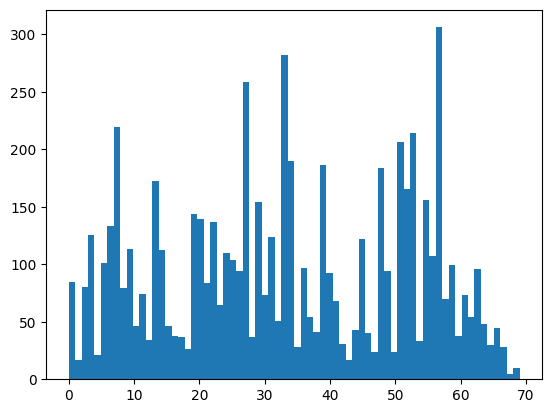

In [93]:
# test data real label
plt.hist(testset_y.cpu().detach().numpy(), bins=70)

(array([ 48.,  35.,  76.,  80.,  37., 100.,  89., 168.,  58., 101.,  59.,
        101.,  57., 222., 119.,  70.,  53.,  40.,  44., 148., 182.,  57.,
        133.,  73.,  76.,  85.,  62., 303.,  17., 172.,  56.,  99.,  56.,
        280., 155.,  29., 106.,  53.,  59., 179.,  77.,  54.,  37.,  42.,
         30.,  69.,  52.,  33., 171.,  97.,  67., 215., 133., 202.,  56.,
        121.,  87., 241.,  90., 126.,  52., 130.,  75.,  71.,  39.,  49.,
         66.,  47.,  28.,  38.]),
 array([ 0.        ,  0.98571429,  1.97142857,  2.95714286,  3.94285714,
         4.92857143,  5.91428571,  6.9       ,  7.88571429,  8.87142857,
         9.85714286, 10.84285714, 11.82857143, 12.81428571, 13.8       ,
        14.78571429, 15.77142857, 16.75714286, 17.74285714, 18.72857143,
        19.71428571, 20.7       , 21.68571429, 22.67142857, 23.65714286,
        24.64285714, 25.62857143, 26.61428571, 27.6       , 28.58571429,
        29.57142857, 30.55714286, 31.54285714, 32.52857143, 33.51428571,
        34.

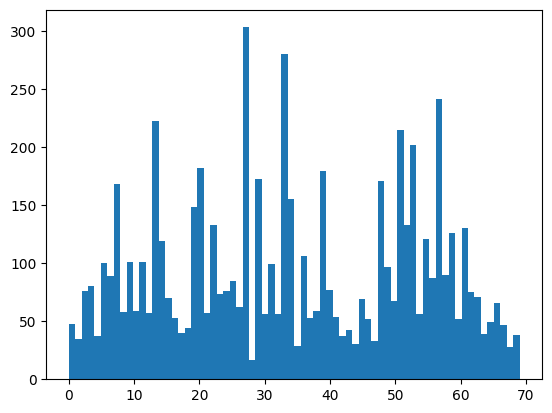

In [94]:
# test data ncm prediction
plt.hist(pred_ncm.cpu().numpy(), bins=70)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
        2., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 2., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1.]),
 array([ 0.        ,  0.98571429,  1.97142857,  2.95714286,  3.94285714,
         4.92857143,  5.91428571,  6.9       ,  7.88571429,  8.87142857,
         9.85714286, 10.84285714, 11.82857143, 12.81428571, 13.8       ,
        14.78571429, 15.77142857, 16.75714286, 17.74285714, 18.72857143,
        19.71428571, 20.7       , 21.68571429, 22.67142857, 23.65714286,
        24.64285714, 25.62857143, 26.61428571, 27.6       , 28.58571429,
        29.57142857, 30.55714286, 31.54285714, 32.52857143, 33.51428571,
        34.5       , 35.48571429, 36.47142857, 37.45714286, 38.44285714,
        39.42857143, 40.41428571, 41.4       , 42.38571429, 43.37142857,
        44.35714286, 

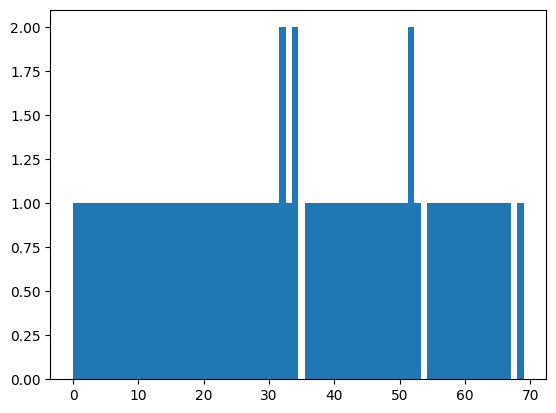

In [89]:
# vnode model prediction
vnode_out = out[-70:,:]
pred = vnode_out.argmax(dim=-1)
plt.hist(pred.cpu().detach().numpy(), bins=70)

(array([ 65.,  25.,  82., 114.,  30., 108., 153., 244.,  72., 104.,  64.,
         62.,  24., 182., 141.,  39.,  44.,  48.,  11., 110., 182.,  55.,
        155.,  36., 141.,  93.,  49., 289.,  16., 173.,  72., 133.,  56.,
        294., 201.,   6., 143.,  58.,  27., 192.,  85.,  59.,  15.,   8.,
         34.,  96.,  35.,  22., 231.,  58.,  35., 252., 113., 226.,   1.,
        204., 114., 268.,  63., 110.,  59.,  96.,  21.,  96.,  47.,  17.,
         28.,  24.,   0.,  22.]),
 array([ 0.        ,  0.98571429,  1.97142857,  2.95714286,  3.94285714,
         4.92857143,  5.91428571,  6.9       ,  7.88571429,  8.87142857,
         9.85714286, 10.84285714, 11.82857143, 12.81428571, 13.8       ,
        14.78571429, 15.77142857, 16.75714286, 17.74285714, 18.72857143,
        19.71428571, 20.7       , 21.68571429, 22.67142857, 23.65714286,
        24.64285714, 25.62857143, 26.61428571, 27.6       , 28.58571429,
        29.57142857, 30.55714286, 31.54285714, 32.52857143, 33.51428571,
        34.

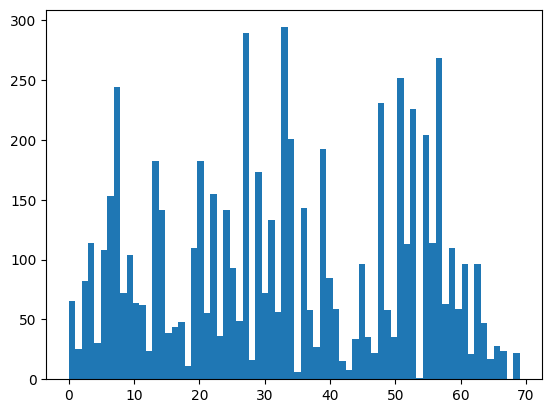

In [95]:
# test data model prediction
pred = out[~data.train_mask].argmax(dim=-1)
plt.hist(pred.cpu().detach().numpy(), bins=70)

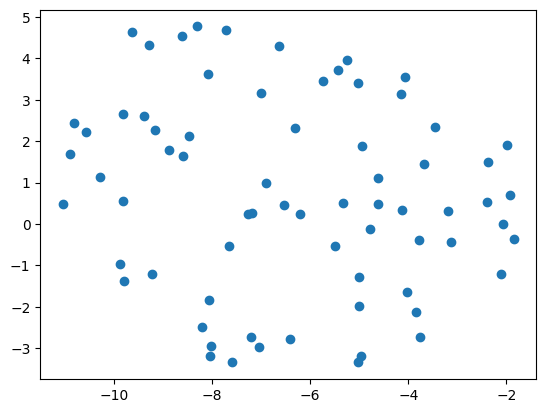

In [96]:
from sklearn.manifold import TSNE
TSNE_emb = TSNE(n_components=3).fit_transform(00 .cpu().detach().numpy())
TSNE_emb = TSNE(n_components=3).fit_transform(00 .cpu().detach().numpy())
plt.scatter(x = TSNE_emb[:,0], y = TSNE_emb[:,1])
plt.scatter(x = TSNE_emb[:,0], y = TSNE_emb[:,1])

In [97]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [99]:
# train data real label
train_y = data.y[data.train_mask]
train_emb = embedding[data.train_mask]
vnode_emb = embedding[-70:,:]

train_ncm_label = torch.cdist(train_emb, vnode_emb).argmin(dim=-1)

report = classification_report(train_ncm_label.cpu(), train_y.cpu(), output_dict=True)

In [102]:
pd.set_option('display.max_rows', 1000)

In [103]:
# classification report for train data ncm and real data
result = pd.DataFrame(report).T
result

,precision,recall,f1-score,support
0,0.468208,0.757009,0.578571,107.000000
1,0.888889,0.400000,0.551724,80.000000
2,0.396341,0.580357,0.471014,112.000000
3,0.496063,0.763636,0.601432,165.000000
4,0.790698,0.557377,0.653846,61.000000
5,0.746341,0.725118,0.735577,211.000000
6,0.613971,0.959770,0.748879,174.000000
7,0.444944,0.589286,0.507042,336.000000
8,0.654321,0.762590,0.704319,139.000000
9,0.734783,0.804762,0.768182,210.000000


In [104]:
# train data real label
train_y = data.y[~data.train_mask]
train_emb = embedding[~data.train_mask]
vnode_emb = embedding[-70:,:]

train_ncm_label = torch.cdist(train_emb, vnode_emb).argmin(dim=-1)

report = classification_report(train_ncm_label.cpu(), train_y.cpu(), output_dict=True)
result = pd.DataFrame(report).T
result

,precision,recall,f1-score,support
0,0.447059,0.791667,0.571429,48.00000
1,0.764706,0.371429,0.500000,35.00000
2,0.487500,0.513158,0.500000,76.00000
3,0.480000,0.750000,0.585366,80.00000
4,0.619048,0.351351,0.448276,37.00000
5,0.702970,0.710000,0.706468,100.00000
6,0.639098,0.955056,0.765766,89.00000
7,0.429224,0.559524,0.485788,168.00000
8,0.493671,0.672414,0.569343,58.00000
9,0.716814,0.801980,0.757009,101.00000


In [105]:
train_y = data.y[data.train_mask]
train_emb = embedding[data.train_mask]
vnode_emb = embedding[-70:,:]

res_cv = {}
res_cc = {}
for i in sorted_node:
    class_emb = train_emb[train_y == i]
    v_class = vnode_emb[i].unsqueeze(0)
    res_cv[i] = torch.cdist(class_emb, v_class).mean().item()
    res_cc[i] = torch.cdist(class_emb, v_class).mean().item()


In [106]:
res_cc

{68: 34.632240295410156,
 69: 9.72427749633789,
 1: 12.720389366149902,
 43: 25.334444046020508,
 4: 18.36745834350586,
 50: 17.373931884765625,
 47: 22.45280647277832,
 18: 32.48036193847656,
 67: 30.648155212402344,
 35: 34.13671875,
 65: 24.863834381103516,
 42: 28.663015365600586,
 54: 30.479351043701172,
 12: 31.283843994140625,
 17: 20.954273223876953,
 28: 29.382360458374023,
 16: 22.60285186767578,
 60: 18.791946411132812,
 46: 29.57152557373047,
 38: 30.871580123901367,
 44: 26.657455444335938,
 66: 33.87057876586914,
 15: 24.543968200683594,
 10: 24.271862030029297,
 64: 30.36423683166504,
 32: 31.234636306762695,
 37: 19.6899471282959,
 62: 32.29444885253906,
 23: 26.63255500793457,
 41: 25.05646514892578,
 58: 28.389707565307617,
 61: 26.927125930786133,
 30: 22.396610260009766,
 11: 28.893699645996094,
 8: 21.9322452545166,
 2: 27.348901748657227,
 21: 29.26746368408203,
 0: 25.35826873779297,
 40: 25.69033432006836,
 26: 36.40130615234375,
 49: 22.97187042236328,
 63: 25.

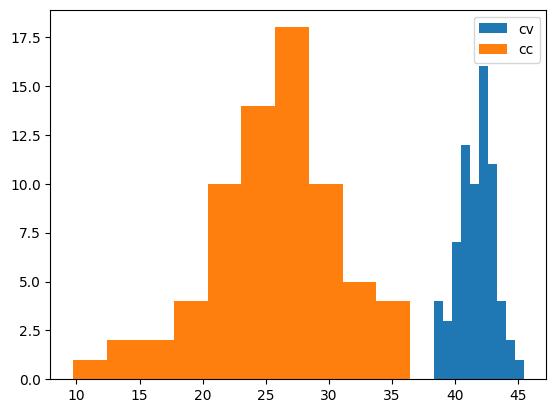

In [80]:
res_cv_lst = res_cv.values()
res_cc_lst = res_cc.values()
plt.hist(res_cv_lst, label='cv')
plt.hist(res_cc_lst, label='cc')
plt.legend()

In [77]:
res_cv

{68: 39.454490661621094,
 69: 42.13810729980469,
 1: 43.02934265136719,
 43: 42.343658447265625,
 4: 42.22315979003906,
 50: 38.681640625,
 47: 41.99478530883789,
 18: 43.56975555419922,
 67: 40.57843017578125,
 35: 41.074764251708984,
 65: 42.1729621887207,
 42: 42.12886428833008,
 54: 40.524436950683594,
 12: 41.593013763427734,
 17: 41.02919006347656,
 28: 41.88157272338867,
 16: 41.577022552490234,
 60: 41.80142593383789,
 46: 40.524349212646484,
 38: 40.27075958251953,
 44: 42.127803802490234,
 66: 42.2730598449707,
 15: 38.64553451538086,
 10: 41.92338943481445,
 64: 42.93474197387695,
 32: 42.83657455444336,
 37: 39.817813873291016,
 62: 41.81827163696289,
 23: 38.56332778930664,
 41: 43.02632141113281,
 58: 41.6673698425293,
 61: 43.875221252441406,
 30: 40.253902435302734,
 11: 41.37599563598633,
 8: 40.64801025390625,
 2: 41.35773468017578,
 21: 43.900115966796875,
 0: 43.270572662353516,
 40: 42.26256561279297,
 26: 42.34693908691406,
 49: 40.73432922363281,
 63: 38.31635284